https://mp.weixin.qq.com/s/QlR528MYCioEuYwJIs20Pg


## 绝对位置编码

公式：
$$\begin{aligned}
P E_{(p o s, 2 i)} &=\sin \left(p o s / 10000^{2 i / d_{\text {model }}}\right) \\
P E_{(p o s, 2 i+1)} &=\cos \left(p o s / 10000^{2 i / d_{\text {model }}}\right)
\end{aligned}$$
`pos`是句子中`word`的位置，`i`是embedding中位置。上边是偶数的公式，下边是奇数的公式。

- 对于固定的`pos`，`embedding`中的每个位置大小如图所示：<br/>
对于`pos`为0:
<img src="图片/capture_20210719130124661.bmp" width="700"/><br/>
对于`pos`为101:
<img src="图片/capture_20210719130224465.bmp" width="700"/>
可见，pos从0到101，图像左边会摆动的越来越厉害；i从0到512，前边的值摆动的厉害，后边的值不再发生变化。

- 对于固定的`i`，`pos`中的每个位置大小如图所示：<br/>
对于`i`为0,1:
<img src="图片/capture_20210719130539418.bmp" width="700"/><br/>
对于`i`为511,512:
<img src="图片/capture_20210719130830621.bmp" width="700"/><br/>
可见，`i`从0,1到511,512，值越来越不变化。

对于短句子加不加`position embedding`都行，但对于长句子，加了`position embedding`提升效果明显，虽然高维度的`embedding`并不起作用。

## 相对位置编码
相对位置并没有完整建模每个输入的位置信息，而是在算 Attention 的时候考虑当前位置与被 Attention 的位置的相对距离

### 2.1 经典式
相对位置编码起源于 Google 的论文《Self-Attention with Relative Position Representations》，后面各种相对位置编码变体基本也是依葫芦画瓢的简单修改。

加入绝对位置编码的attention公式

$$\left\{\begin{aligned} \boldsymbol{q}_{i} &=\left(\boldsymbol{x}_{i}+\boldsymbol{p}_{i}\right) \boldsymbol{W}_{Q} \\ \boldsymbol{k}_{j} &=\left(\boldsymbol{x}_{j}+\boldsymbol{p}_{j}\right) \boldsymbol{W}_{K} \\ \boldsymbol{v}_{j} &=\left(\boldsymbol{x}_{j}+\boldsymbol{p}_{j}\right) \boldsymbol{W}_{V} \\ a_{i, j} &=\operatorname{softmax}\left(\boldsymbol{q}_{i} \boldsymbol{k}_{j}^{\top}\right) \\ \boldsymbol{o}_{i} &=\sum_{j} a_{i, j} \boldsymbol{v}_{j} \end{aligned}\right.$$

$$\boldsymbol{q}_{\boldsymbol{i}} \boldsymbol{k}_{j}^{\top}=\left(\boldsymbol{x}_{i}+\boldsymbol{p}_{i}\right) \boldsymbol{W}_{Q} \boldsymbol{W}_{K}^{\top}\left(\boldsymbol{x}_{j}+\boldsymbol{p}_{j}\right)^{\top}=\left(\boldsymbol{x}_{i} \boldsymbol{W}_{Q}+\boldsymbol{p}_{i} \boldsymbol{W}_{Q}\right)\left(\boldsymbol{W}_{K}^{\top} \boldsymbol{x}_{j}^{\top}+\boldsymbol{W}_{K}^{\top} \boldsymbol{p}_{j}^{\top}\right)$$

1. 为了加入相对位置信息，Google把$p_iW_Q$去掉，$p_jW_K$换成$R_{i,j}^K$。变成：

$$a_{i, j}=\operatorname{softmax}\left(\boldsymbol{x}_{i} \boldsymbol{W}_{Q}\left(\boldsymbol{x}_{j} \boldsymbol{W}_{K}+\boldsymbol{R}_{i, j}^{K}\right)^{\top}\right)$$

把$o_i$展开：

$$\boldsymbol{o}_{i}=\sum_{j} a_{i, j} \boldsymbol{v}_{j}=\sum_{j} a_{i, j}\left(\boldsymbol{x}_{j} \boldsymbol{W}_{V}+\boldsymbol{p}_{j} \boldsymbol{W}_{V}\right)$$

2. Google又把$p_jW_V$变成$R_{i,j}^V$：

$$\boldsymbol{o}_{i}=\sum_{j} a_{i, j}\left(\boldsymbol{x}_{j} \boldsymbol{W}_{V}+\boldsymbol{R}_{i, j}^{V}\right)$$

3. Google进行了裁剪

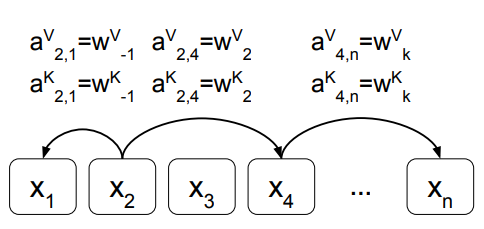

注意clip函数是进行了裁剪，k是超参数：

$$\begin{aligned} R_{i j}^{K} &=w_{\mathrm{clip}(j-i, k)}^{K} \\ R_{i j}^{V} &=w_{\mathrm{clip}(j-i, k)}^{V} \end{aligned}$$
$$\operatorname{clip}(x, k)=\max (-k, \min (k, x))$$

<b>所以Google加入相对位置编码就是加入了$R_{i,j}^K$与$R_{i,j}^V$(可转换为$w^{K}=\left(w_{-k}^{K}, \ldots, w_{k}^{K}\right)$ 和 $w^{V}=\left(w_{-k}^{V}, \ldots, w_{k}^{V}\right)$)，而这两个矩阵可以是可学习的参数。<b/>

In [8]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable

In [6]:
def clip(a, b):
    return max(-b, min(a, b))

In [30]:
# 计算R矩阵
def matrixR(x, k=None):
    batch_size = x.size(0)
    heads = x.size(1)
    seq_len = x.size(-2)
    d_k = x.size(-1)
    
    if k is None:
        k = seq_len - 4
        
    if k < 2:
        k = 2
    
    w = np.random.normal(0, 1, size=(2*k+1, d_k))
    R = np.zeros((batch_size, 1, seq_len, seq_len, d_k))
    for i in range(seq_len):
        for j in range(seq_len):
            R[:,:,i,j,:] = w[clip(j-i, k),:]
            
    return R

In [31]:
# 一个batch，两个句子，一个句子4个embedding, 每个embedding有4维
x = [[[-3.1010,  3.0988, -1.3545,  3.3511],
         [-1.5784,  1.3254, -0.2466, -0.5483],
         [-3.8037, -1.0925, -2.0817, -4.5298],
         [-0.2510,  0.9893, -0.8365, -0.8189]],

        [[-3.8037, -1.0925, -2.0817, -4.5298],
         [-3.1010,  3.0988, -1.3545,  3.3511],
         [ 0.2816,  1.5528, -0.7460, -3.6551],
         [ 0.3563,  1.8566,  1.4065, -2.0100]]]
x = torch.tensor(x)
matrixR(x)

array([[[[[-0.38889075,  0.2655359 ,  0.55510042, -2.45709074],
          [-0.58475525,  0.38610033, -1.01850389, -0.02605846],
          [ 1.38153885,  0.99600121, -0.35653947,  0.51336005],
          [ 1.38153885,  0.99600121, -0.35653947,  0.51336005]],

         [[-2.15918999, -0.33463596, -0.18015831, -1.72284773],
          [-0.38889075,  0.2655359 ,  0.55510042, -2.45709074],
          [-0.58475525,  0.38610033, -1.01850389, -0.02605846],
          [ 1.38153885,  0.99600121, -0.35653947,  0.51336005]],

         [[-0.30118161, -0.43487561,  0.75462576, -0.77575317],
          [-2.15918999, -0.33463596, -0.18015831, -1.72284773],
          [-0.38889075,  0.2655359 ,  0.55510042, -2.45709074],
          [-0.58475525,  0.38610033, -1.01850389, -0.02605846]],

         [[-0.30118161, -0.43487561,  0.75462576, -0.77575317],
          [-0.30118161, -0.43487561,  0.75462576, -0.77575317],
          [-2.15918999, -0.33463596, -0.18015831, -1.72284773],
          [-0.38889075,  0.2655359

In [32]:
# q:[batch_size, heads, seq_len, d_k] 
def attention(q, k, v, d_k, mask=None, dropout=None):
    # R_{i,j}^K : [batch_size, 1, seq_len, seq_len, d_k]
    Rk = matrixR(k)
    Rk = Variable(Rk, requires_grad=True)
    
    # R_{i,j}^V
    Rv = matrixR(v)
    Rv = Variable(Rv, requires_grad=True)
    
    # 太难了，不会写
    # score = [batch_size, heads, seq_len, seq_len]
    score = (torch.matmul(q, k.transpose(-2, -1)) + torch.matmul(q, Rk.transpose())) / math.sqrt(d_k)
    
    #  mask 机制，在 Transformer 中有 attention、encoder 和 decoder 中，有不同的应用
    if mask is not None:
        score = score.masked_fill(mask == 0, -1e9)
        
    
    
        
    softmax = F.softmax(score[-1])
    
    if dropout is not None:
        softmax = dropout(softmax)
    
    output = torch.matmul(softmax, v)
    return output